# №16. U-Net

1. [Threshold U-Net: бинаризация изображений (сканов) с текстом](https://habr.com/ru/companies/smartengines/articles/881148)
2. [U-net для решения семантической сегментации](https://blog.deepschool.ru/cv/unet)
    - В конце ссылки на полезные источники
3. [Примеры использования обученных U-net моделей](https://github.com/qubvel-org/segmentation_models.pytorch?tab=readme-ov-file#-examples-)
    - [Car segmentation(camvid).ipynb](https://colab.research.google.com/github/qubvel/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb#scrollTo=TjKb-VMmN2XT) и др.
4. [U-Net для МРТ головного мозга](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/mateuszbuda_brain-segmentation-pytorch_unet.ipynb#scrollTo=fa3609e1)

## 1. Краткая теория

***Устройство модели U-Net***
<table>
  <tr>
    <th>Архитектура модели U-Net, представленной для решения задачи <br>
    бинаризации медицинских снимков в 2015 году</th>
    <th>Пример U-Net для задачи бинаризации</th>
  </tr>
  <tr>
    <td><img src="data/my_images/unet_schema.png" width="550"></td>
    <td><img src="data/my_images/unet_threshold_schema.png" width="550"></td>
  </tr>
</table>

## 2. Собственная реализация U-Net

In [32]:
import torch
import torch.nn as nn

import torchvision
from torchvision.transforms import v2

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### 2.1 Реализация U-Net

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, (3, 3), padding=1)
        self.act = nn.ReLU(True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        out = self.act(x)

        return out

In [3]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down = nn.MaxPool2d(2)

    def forward(self, x):
        out_double_conv = self.double_conv(x)
        out_down = self.down(out_double_conv)

        return out_double_conv, out_down

In [4]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, (2, 2), stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], dim=1)
        out = self.double_conv(x)

        return out

In [36]:
class UNet(nn.Module):
    def __init__(self, in_channels:int=3, num_classes:int=1):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        self.down1 = DownSample(self.in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)

        self.out = nn.Conv2d(64, self.num_classes, (1, 1))

    def forward(self, x):
        sk1, x = self.down1(x)
        sk2, x = self.down2(x)
        sk3, x = self.down3(x)
        sk4, x = self.down4(x)

        x = self.bottleneck(x)

        x = self.up1(x, sk4)
        x = self.up2(x, sk3)
        x = self.up3(x, sk2)
        x = self.up4(x, sk1)

        out = self.out(x)

        return out

In [37]:
model = UNet(in_channels=3, num_classes=3)
model;

In [38]:
input = torch.rand([1, 3, 512, 512])
model.eval()
pred = model(input)
pred.shape

torch.Size([1, 3, 512, 512])

### 2.2 Тестирование собственной U-Net (необученной)

In [39]:
transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(512),
    v2.CenterCrop(512),
    v2.ToDtype(dtype=torch.float32, scale=True),
    # mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

transform

Compose(
      ToImage()
      Resize(size=[512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      CenterCrop(size=(512, 512))
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.3088455].


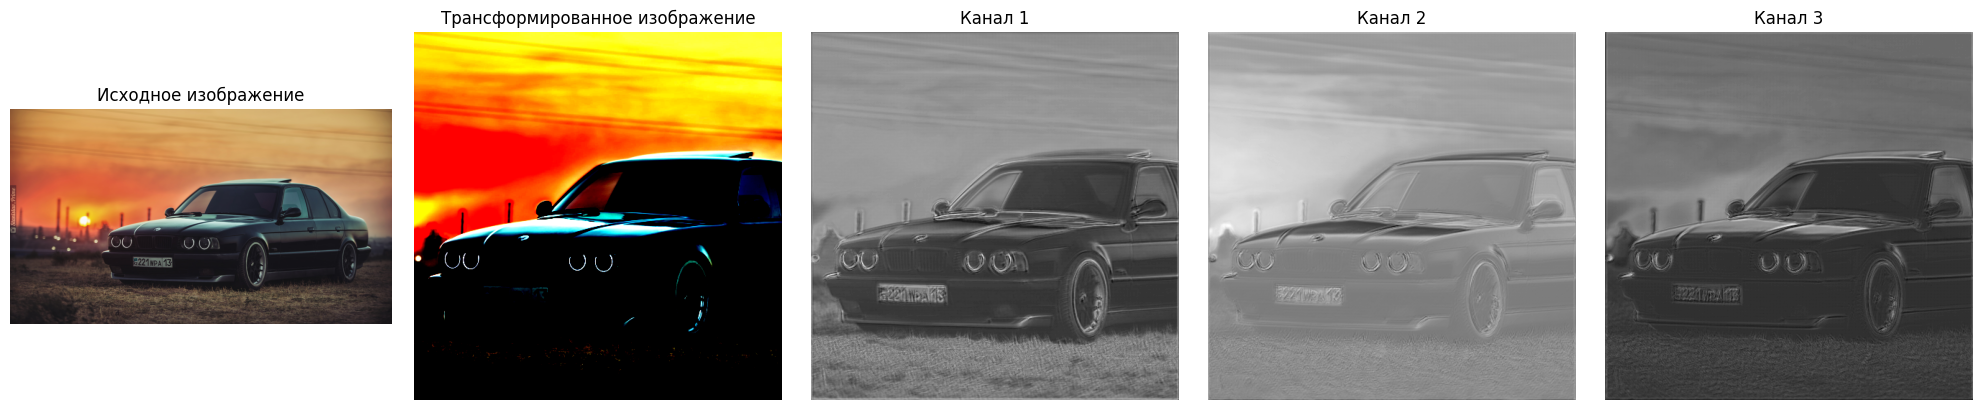

In [44]:
img = Image.open('data/my_images/my_love.jpg')

# Преобразуем и пропускаем через модель
input = transform(img)
model.eval()
with torch.no_grad():
    pred = model(input.unsqueeze(0))
output = pred.squeeze(0).detach()

# Определяем количество каналов для выходных данных
num_channels = output.shape[0]

# Количество колонок: 2 (исходное + трансформированное) + 3 (так захотел)
ncols = 5
nrows = (num_channels + 2 + ncols - 1) // ncols  # округление вверх, 2 - для исходного и трансформированного изображений

fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 4))
axes = np.array(axes).reshape(-1)

# 1. Исходное изображение
axes[0].imshow(img)
axes[0].set_title("Исходное изображение")
axes[0].axis('off')

# 2. Трансформированное изображение
axes[1].imshow(input.permute(1,2,0), cmap='gray')
axes[1].set_title("Трансформированное изображение")
axes[1].axis('off')

# 3. Каналы выхода модели (столько, сколько num_channels, начиная с axes[2])
for i in range(num_channels):
    axes[i+2].imshow(output[i, :, :], cmap='gray')
    axes[i+2].set_title(f"Канал {i+1}")
    axes[i+2].axis('off')

# Если каналов меньше, чем оставшиеся ячейки в subplot, отключим оставшиеся пустые оси
for i in range(num_channels + 2, ncols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 3. U-Net в `segmentation-models-pytorch`

In [ ]:
# pip install segmentation-models-pytorch

Гитхаб библиотеки с документацией и примерами:
[GitHub: segmentation_models_pytorch >> Quick start](https://github.com/qubvel-org/segmentation_models.pytorch?tab=readme-ov-file#-quick-start-)

In [48]:
import segmentation_models_pytorch as smp

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

### 3.1 Загрузка модели

In [49]:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

d:\code-files\unik\ML\.ML-venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\trxxnk\.cache\huggingface\hub\models--smp-hub--resnet34.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP d

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

### 3.1 Тест 1 - просмотр выходных каналов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.3088455].


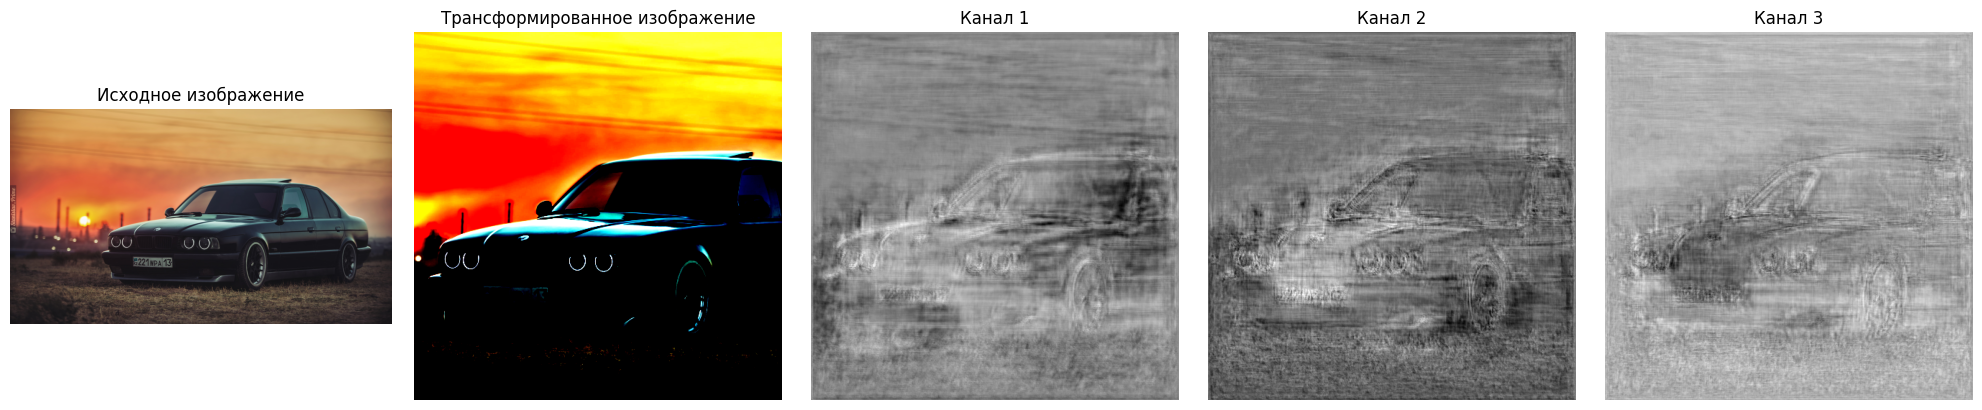

In [50]:
img = Image.open('data/my_images/my_love.jpg')

# Преобразуем и пропускаем через модель
input = transform(img)
model.eval()
with torch.no_grad():
    pred = model(input.unsqueeze(0))
output = pred.squeeze(0).detach()

# Определяем количество каналов для выходных данных
num_channels = output.shape[0]

# Количество колонок: 2 (исходное + трансформированное) + 3 (так захотел)
ncols = 5
nrows = (num_channels + 2 + ncols - 1) // ncols  # округление вверх, 2 - для исходного и трансформированного изображений

fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 4))
axes = np.array(axes).reshape(-1)

# 1. Исходное изображение
axes[0].imshow(img)
axes[0].set_title("Исходное изображение")
axes[0].axis('off')

# 2. Трансформированное изображение
axes[1].imshow(input.permute(1,2,0), cmap='gray')
axes[1].set_title("Трансформированное изображение")
axes[1].axis('off')

# 3. Каналы выхода модели (столько, сколько num_channels, начиная с axes[2])
for i in range(num_channels):
    axes[i+2].imshow(output[i, :, :], cmap='gray')
    axes[i+2].set_title(f"Канал {i+1}")
    axes[i+2].axis('off')

# Если каналов меньше, чем оставшиеся ячейки в subplot, отключим оставшиеся пустые оси
for i in range(num_channels + 2, ncols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 3.2 Тест 2 - отображение маски (модель не обучена)

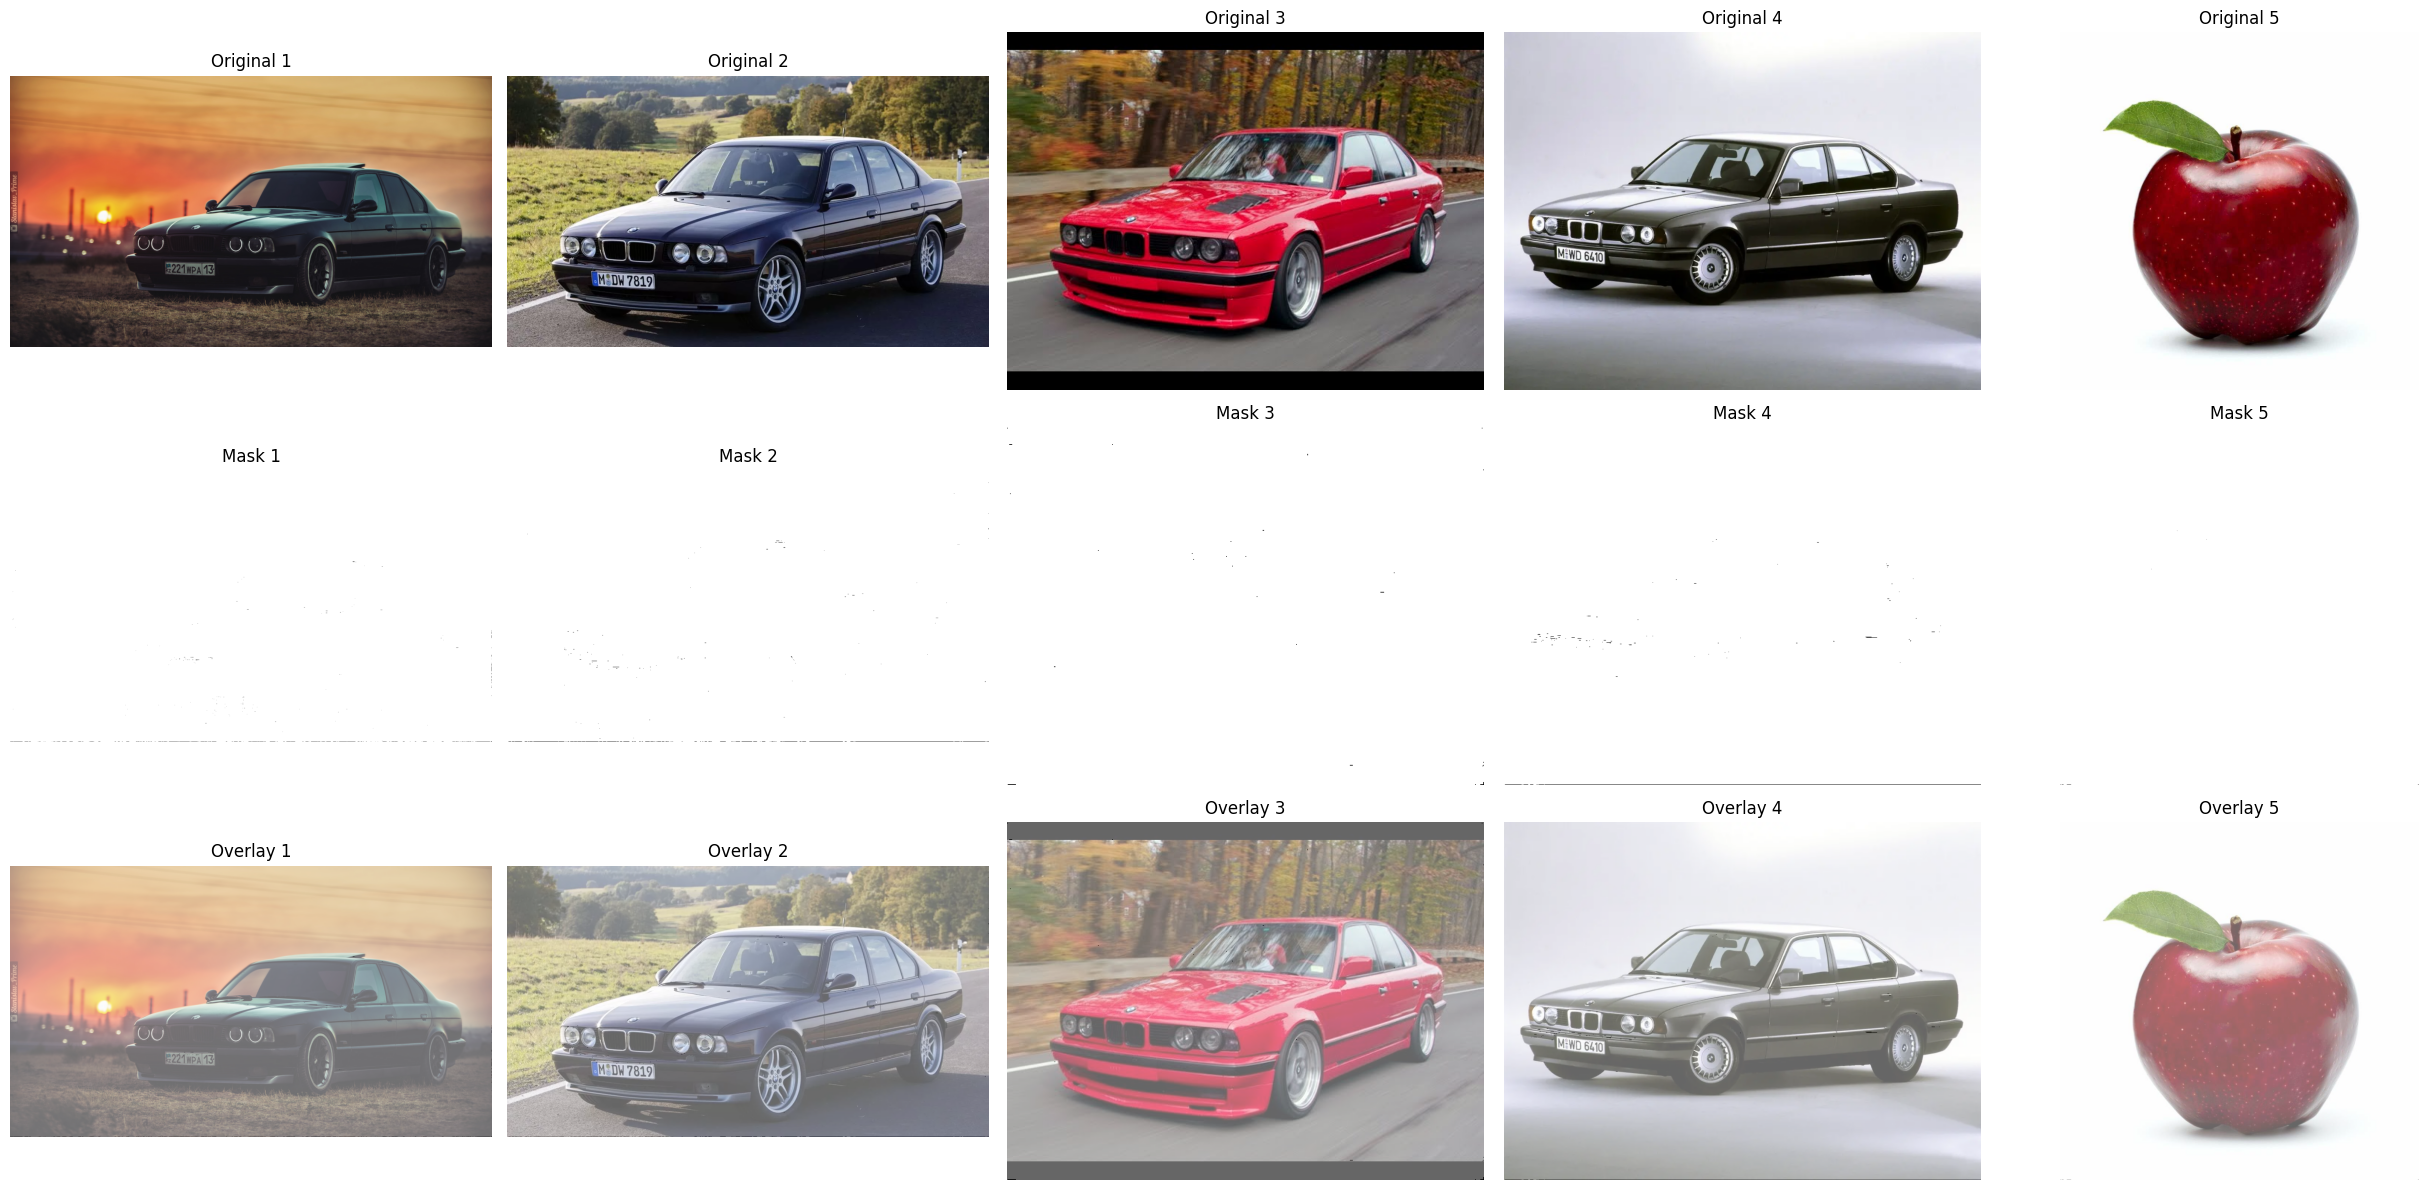

In [ ]:
def infer_mask(image_path, model, transform_fn, threshold=0.5):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    inp = transform_fn(image_rgb).transpose(2, 0, 1)
    inp = torch.from_numpy(inp).unsqueeze(0).float()

    model.eval()
    with torch.no_grad():
        pred = model(inp)
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()
    
    mask = (pred > threshold).astype(np.uint8)
    overlay = (image_rgb * 0.6 + np.dstack([mask*255]*3) * 0.4).astype(np.uint8)

    return image_rgb, mask * 255, overlay


# ✅ Пример списка изображений
image_paths = image_paths = [
    'data/my_images/my_love.jpg',
    'data/my_images/my_love_2.png', 
    'data/my_images/my_love_3.png',
    'data/my_images/my_love_4.png',
    'data/my_images/apple.png'
]

# ✅ Получение результатов
results = [infer_mask(p, model, transform) for p in image_paths]

# ✅ Визуализация на subplots (в одну строку)
fig, axes = plt.subplots(3, len(results), figsize=(5 * len(results), 12))

if len(results) == 1:
    # Если одно изображение — обрабатываем отдельно
    results = [results[0]]

for i, (img, mask, overlay) in enumerate(results):
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis("off")
    
    axes[1, i].imshow(mask, cmap="gray")
    axes[1, i].set_title(f"Mask {i+1}")
    axes[1, i].axis("off")
    
    axes[2, i].imshow(overlay)
    axes[2, i].set_title(f"Overlay {i+1}")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()

SMP **не даёт предобученный U-Net для COCO / Pascal VOC автоматически**.

Он даёт только *предобученные энкодеры (`resnet34`)*, но **декодер не обучен сегментации автомобилей**.

---

***Поэтому***:

| Ситуация                                                        | Что нужно сделать                                                                                 |
| --------------------------------------------------------------- | ------------------------------------------------------------------------------------------------- |
| Ты **уже обучил модель на датасете auto / non-auto**            | Всё ок — просто используй код выше.                                                               |
| Ты **ещё не обучал** и хочешь **выделять авто на обычных фото** | Нужно дообучить на **Pascal VOC (class=car)** или **COCO (category=car)**                         |
| Ты **хочешь готовую модель без обучения**                       | Лучше взять **DeepLabV3 ResNet50 (pretrained COCO)** из `torchvision` — там класс "car" уже есть. |

---